# Imports

In [10]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt


This part under takes the data set from MNIST with all the numbers and labels for what the numbers should be and spilts it up into:
figs = the image and its data
figsValue = what the image should be labeled as 

Text(0.5, 1.0, 'Number is 4')

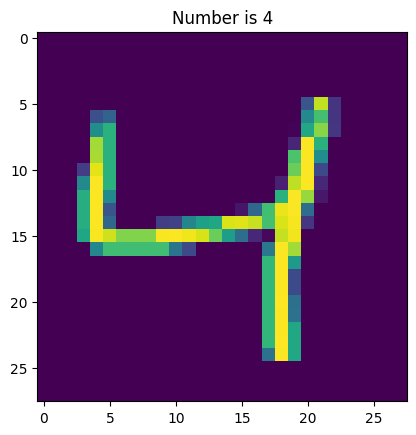

In [20]:
figs, figsValue = torch.load("C:\\Users\\caker\\GitHubRepos\\neuralNet\\DataMNIST\\processed\\training.pt")

plt.imshow(figs[2].numpy())
plt.title(f'Number is {figsValue[2].numpy()}')


Now we take the `figsValue` and turn it into a 10 dimensional vector (because there are numbers 0-9 in the data set) and make it have 1 for the label its supposed to display
e.g figValue[1] = "4" => figValue[1] = "0000100000"
we do this with a "one hot encoder" whatever that is


In [15]:
figsValue = F.one_hot(figsValue,num_classes=10)
figsValue.shape

torch.Size([60000, 10])

So now we have to deal with the `figs` becasue currentally this is 6000 28x28 matrix's (i think) but it'd be nicer if it was 6000 784 dimiensional vectors (28^2). So we change that now 

In [16]:
figs.view(-1,28**2).shape

torch.Size([60000, 784])

Ok now we know how to setup the data so that we can train it now we will make it easier to train. 

Okay now we have to make an dataset object so its easier to train (i think).Some points here to notice are:
- The CTDataset class has a inheritance relationship with the Dataset class of torch.utils.data
- The `figs` data is loaded and then normilized because the pixels are form 0-255 (which indiactes brightness) to now between 0-1
- The `figs` data is not into a 784 dimesinol vector yet (because we want to be able to plot these images)
- You have to overide some of these functions so that we can use some methods on this object later (len,getitem)

In [22]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.figs, self.figsValue = torch.load(filepath)
        self.figs = self.figs / 255.
        self.figsValue = F.one_hot(self.figsValue, num_classes=10).to(float)
    def __len__(self): 
        return self.figs.shape[0]
    def __getitem__(self, ix): 
        return self.figs[ix], self.figsValue[ix]

Now we spilt it into two different data sets (80/20 rule) but I think this data set is accutally a bit different. 

In [23]:
trainDS = CTDataset("C:\\Users\\caker\\GitHubRepos\\neuralNet\\DataMNIST\\processed\\training.pt")
testDS = CTDataset("C:\\Users\\caker\\GitHubRepos\\neuralNet\\DataMNIST\\processed\\test.pt")

In [24]:
len(trainDS)

60000

Cool now what we need to is to 